# PreProcessing and Data Preparation

In [1]:
## Enviroment Setup
import os, sys
import cv2
from PIL import Image

from utils.image_utils import read_img, image_align, get_face_mask, resize_image_proportionally
from utils.matting_utils import load_matting_model, matting_single_image
from utils.mp2dlib import convert_landmarks_mediapipe_to_dlib
from utils.general_utils import plot_landmarks

In [2]:

WORKING_DIR = '/home/dipcik/avatar/flame-head-tracker-temiz'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())

## Computing Device
device = 'cuda:0'
import torch
torch.cuda.set_device(device) # this will solve the problem that OpenGL not on the same device with torch tensors

import matplotlib.pyplot as plt
import numpy as np

from tracker_base import Tracker

Current Working Directory:  /home/dipcik/avatar/flame-head-tracker-temiz


2025-09-21 02:28:46.103584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
tracker_cfg = {
    'mediapipe_face_landmarker_v2_path': './models/face_landmarker.task', 
    'flame_model_path': './models/FLAME2020/generic_model.pkl',
    'flame_lmk_embedding_path': './models/landmark_embedding.npy',
    'ear_landmarker_path': './models/ear_landmarker.pth', # this is optional, if you do not want to use ear landmarks during fitting, just remove this line
    'tex_space_path': './models/FLAME_albedo_from_BFM.npz',
    'face_parsing_model_path': './models/79999_iter.pth',
    'template_mesh_file_path': './models/head_template.obj',
    'result_img_size': 512,
    'use_matting': True,           # use image/video matting to remove background
    'optimize_fov': True,          # whether to optimize the camera FOV, NOTE: this feature is still experimental
    'device': device,
}

tracker = Tracker(tracker_cfg)


I0000 00:00:1758410929.912330 3455651 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1758410929.976378 3455754 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 560.35.05), renderer: NVIDIA GeForce RTX 3060/PCIe/SSE2
W0000 00:00:1758410929.976777 3455651 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1758410929.981965 3455759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1758410929.997213 3455770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Using cache found in /home/dipcik/.cache/torch/hub/PeterL1n_RobustVideoMatting_master


creating the FLAME Decoder


/home/dipcik/avatar/flame-head-tracker-temiz/submodules/flame_lib/FLAME.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_faces_idx', torch.tensor(lmk_embeddings['dynamic_lmk_faces_idx'], dtype=torch.long))
/home/dipcik/avatar/flame-head-tracker-temiz/submodules/flame_lib/FLAME.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_bary_coords', torch.tensor(lmk_embeddings['dynamic_lmk_bary_coords'], dtype=self.dtype))
/home/dipcik/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:551: UserWarning: Mtl file does not exist: ./models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
/

creating the FLAME Decoder
trained model found. load models/deca_model.tar


/home/dipcik/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:551: UserWarning: Mtl file does not exist: models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")



>>> Flame Head Tracker v4.1 ready.


### Pipeline Step 0 : Read Image

Original Image Shape:  (900, 600, 3)


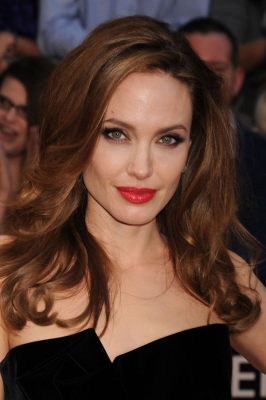

In [4]:
img_path = './assets/FFHQ/00002.png'
img_path = './assets/woman.jpg'

img = read_img(img_path)
print("Original Image Shape: ", img.shape)

Image.fromarray(resize_image_proportionally(img,max_length=400))

### Pipeline Step 1 : Apply Matting

In [5]:
img = matting_single_image(tracker.video_matting_model, img)

Matted Image Shape:  (900, 600, 3)


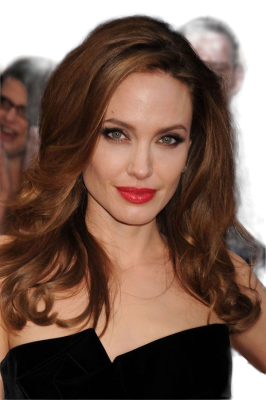

In [6]:
print("Matted Image Shape: ", img.shape)
# Matted Image
Image.fromarray(resize_image_proportionally(img,max_length=400))

### Pipeline Step 2 : Image Alignment

The face alignment process extracts facial landmarks, computes reference points (eyes and mouth), and defines a crop rectangle based on face geometry. It then processes the image through shrinking, cropping, padding, and geometric transformation to standardize orientation. The final output is a consistently scaled, centered, and upright face image (default 256×256), optimized for reliable tracking and reconstruction.

In [7]:
# realign image
lmks_dense, blend_scores = tracker.mediapipe_face_detection(img)
if lmks_dense is None:
    # no face detected
    print("No face detected!")

W0000 00:00:1758410949.574616 3455762 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [8]:
lmks_68 = convert_landmarks_mediapipe_to_dlib(lmks_mp=lmks_dense)
img_aligned = image_align(img, face_landmarks=lmks_68, output_size=tracker.IMG_SIZE, 
                            standard='tracking', padding_mode='constant')

img_org = img.copy()
realign = True
if realign:
    # if realign == True
    # update img to the aligned image, which will be used in fitting
    img = img_aligned

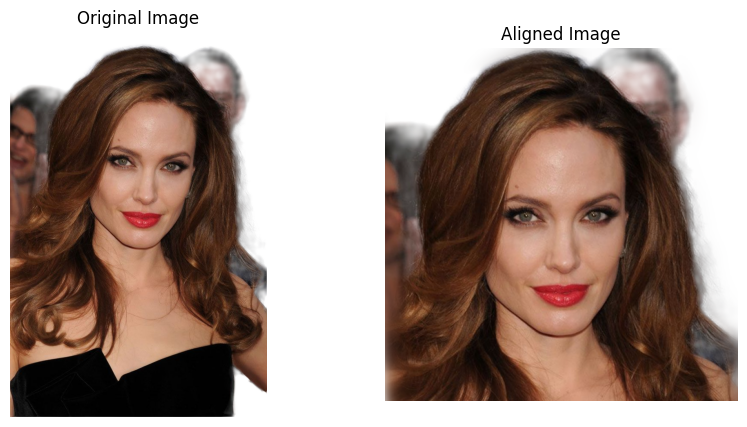

In [9]:
# plot img and img_aligned side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_org)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(img_aligned)
ax[1].set_title('Aligned Image')
ax[1].axis('off')
plt.show()

### Pipeline Step 3 : Face Parsing

The parsing mask helps the optimization process by:
 - Identifying face regions for photometric fitting 
 - Creating face masks to exclude background/hair regions 
 - Focusing optimization on relevant facial areas.
   
The parsing mask contains labels 0-18 representing:
  - 0: background
  - 1: skin
  - 2-6: eyebrows, eyes
  - 7-9: ears
  - 10: nose
  - 11-13: mouth, lips
  - 14-15: neck
  - 16-18: cloth, hair, hat

 This segmentation helps the FLAME fitting process focus on actual facial features and ignore irrelevant regions.

In [ ]:
# run face parsing
parsing_mask = tracker.face_parser.run(img)
if realign:
    parsing_mask_aligned = parsing_mask
else: 
    parsing_mask_aligned = tracker.face_parser.run(img_aligned)


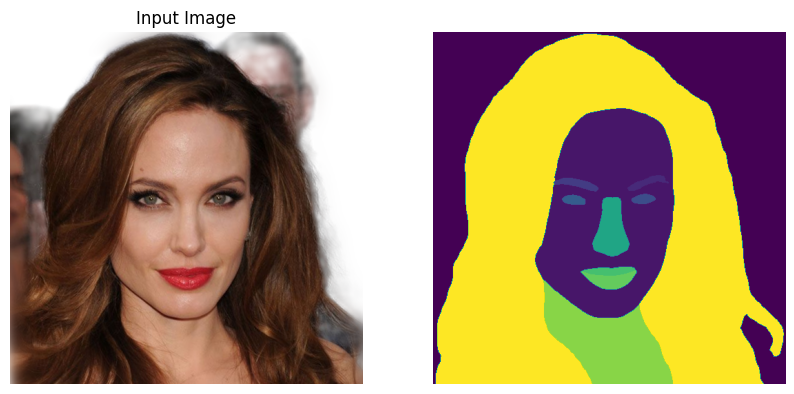

In [11]:
# plot img and pasrsing mask side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))   
ax[0].imshow(img)
ax[0].set_title('Input Image')
ax[0].axis('off')
ax[1].imshow(parsing_mask_aligned)
ax[1].axis('off')
plt.show()

### Pipeline Step 4 : Detect Landmarks

In [12]:
# detect landmarks (to output)
ret_dict_lmks = tracker.detect_face_landmarks(img)
if ret_dict_lmks is None: 
    print("No landmarks detected!")
else: 
    lmks_dense, lmks_68, lmks_eyes, blend_scores = tracker.unpack_face_landmarks_result(ret_dict_lmks)

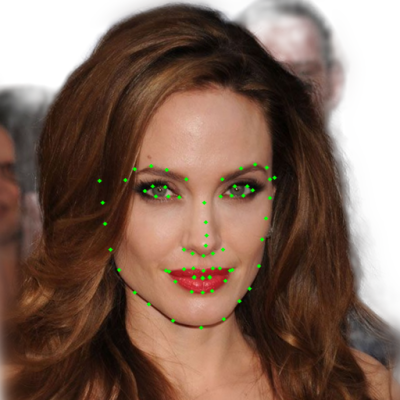

In [13]:
plot_img = plot_landmarks(img, lmks_68, color=(0, 255, 0), radius=2, thickness=-1, copy=True)
Image.fromarray(resize_image_proportionally(plot_img,max_length=400))

### STAGE 0 : Initial FLAME Fitting (MICA/DECA)

In [14]:
# run neural network FLAME reconstruction models
recon_dict = tracker.run_reconstruction_models(img = np.copy(img), lmks_68 = np.copy(lmks_68))

In [15]:
# resize image to match the mesh renderer's output size
img_resized = cv2.resize(img, (tracker.RENDER_SIZE, tracker.RENDER_SIZE))

In [16]:
# run landmark detector again on resized image
ret_dict_lmks_resized = tracker.detect_face_landmarks(img_resized)
if ret_dict_lmks_resized is None:
    print("No landmark detected")
else: 
    _, lmks_68_resized, lmks_eyes_resized, _ = tracker.unpack_face_landmarks_result(ret_dict_lmks_resized)

In [17]:
# normalize the face landmarks to -1.0 ~ 1.0 (only normalize along x and y axes)
lmks_68_resized[:, :2] = lmks_68_resized[:, :2] / float(tracker.RENDER_SIZE) * 2 - 1
lmks_eyes_resized[:, :2] = lmks_eyes_resized[:, :2] / float(tracker.RENDER_SIZE) * 2 - 1

In [18]:
# prepare ear 20 landmarks
if tracker.use_ear_landmarks: 
    ear_landmarks = tracker.detect_ear_landmarks(img_resized)  # [20, 2] normalized ear landmarks
    ear_landmarks = ear_landmarks[None] # [1, 20, 2]


In [19]:
# prepare the input dictionary to optimizer
in_dict = {
    'img':  np.array([img], dtype=np.uint8),                  # [1, H, W, 3]
    'parsing': parsing_mask[None],                            # [1, 512, 512]
    'img_resized':  np.array([img_resized], dtype=np.uint8),  # [1, 256, 256, 3]
    'img_aligned':  np.array([img_aligned], dtype=np.uint8),  # [1, H, W, 3]
    'parsing_aligned':  parsing_mask_aligned[None],           # [1, 512, 512]
    'shape': recon_dict['shape'],                             # [1, D_shape]
    'exp':   recon_dict['exp'],                               # [1, D_exp]
    'head_pose':  recon_dict['head_pose'],                    # [1, 3]
    'jaw_pose':  recon_dict['jaw_pose'],                      # [1, 3]
    'tex':   recon_dict['tex'],                               # [1, D_tex]
    'light': recon_dict['light'],                             # [1, 9, 3]
    'blendshape_scores': blend_scores[None],                  # [1, 52]
    'gt_landmarks':     lmks_68_resized[None],                # [1, 68, 3]
    'gt_eye_landmarks': lmks_eyes_resized[None],              # [1, 10, 3]
}
if tracker.use_ear_landmarks:
    in_dict['gt_ear_landmarks'] = ear_landmarks               # [1, 20, 3]


### STAGE 1-2 : Flame Fitting (Landmark / Photometric)

In [20]:
photometric_fitting = True
shape_code = None
texture=None
temporal_smoothing=False
estimate_canonical=False

if photometric_fitting:
    if texture is not None:
        in_dict['texture'] = texture # [1,3,256,256]
    face_mask_resized = []
    for i in range(len(in_dict['parsing'])):
        parsing_mask = in_dict['parsing'][i] # [512,512]
        _face_mask_ = get_face_mask(parsing=parsing_mask, 
                                keep_mouth = False, 
                                keep_ears = False,
                                keep_neck = False) # [512,512]
        _face_mask_resized_ = cv2.resize(_face_mask_, (tracker.RENDER_SIZE, tracker.RENDER_SIZE)) # [256,256]
        face_mask_resized.append(_face_mask_resized_)
    in_dict['face_mask_resized'] = np.array(face_mask_resized) # [N,256,256]
    # run photometric fitting
    ret_dict = tracker.run_fitting_photometric(in_dict=in_dict, shape_code=shape_code, 
                                            temporal_smoothing=temporal_smoothing, estimate_canonical=estimate_canonical)
else:
    # run facial landmark-based fitting
    ret_dict = tracker.run_fitting(in_dict=in_dict, shape_code=shape_code, temporal_smoothing=temporal_smoothing)


### Results : Optimized Flame Model 

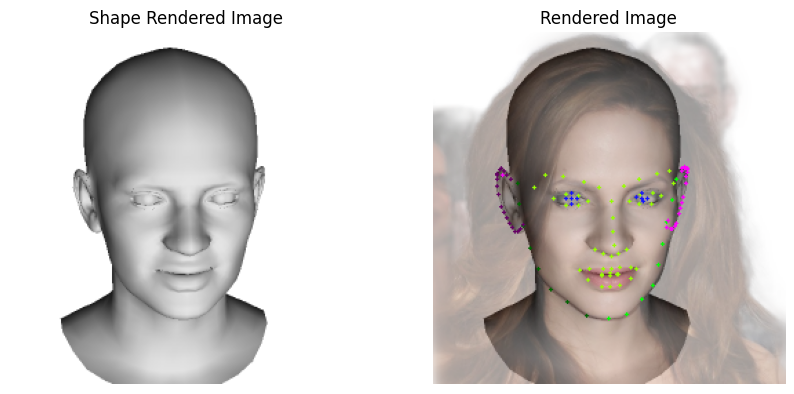

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))   
ax[0].imshow(ret_dict['shape_rendered'][0])
ax[0].set_title('Shape Rendered Image')
ax[0].axis('off')
ax[1].imshow(ret_dict['img_rendered'][0])
ax[1].set_title('Rendered Image')
ax[1].axis('off')
plt.show()